## *Reflexion Agents*

*A reflexion agent is an AI system that improves its own performance through cycles of self-critique and revision. After generating an initial output, it explicitly reflects on what could be improved, applies those improvements, and repeats this process. This approach leads to higher quality results, especially in tasks where accuracy and thoroughness are more important than speed.*

The reflexion agent has  3 main components:
- Actor (agent) with self-reflection
- External evaluator (task-specific, e.g. code compilation steps)
- Episodic memory that stores the reflections from

### *Actor Agent (with reflection)* 

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include: 
1. Tools/tool execution 
2. Initial responder: generate an initial response (and self-reflection) 
3. Revisor: re-respond (and reflec) based on previous reflections

Initial Response has - 
- Response 
- Critique
- Search Keyworlds

Revisor's Response has -
- Response
- Critique
- Search Keywords
- Citations


### *Implement Reflexion Actor*

In [90]:
import datetime
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_core.messages import HumanMessage
from langchain_core.output_parsers.openai_tools import (
    JsonOutputToolsParser,
    PydanticToolsParser,
)
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI


##### Creating Actor Prompt Template

In [91]:
actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        ("system", "Answer the user's question above using the required format."),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)

##### Creating the schemas for output we want - 

In [92]:
from typing import List
from pydantic import BaseModel, Field


class Reflection(BaseModel):
    # This class will have all info about reflection, about what critic want to address
    missing_info: str = Field(description="Critique of what is missing info.")
    unnecessary_info: str = Field(description="Critique of what is unnecessary info")

class AnswerQuestion(BaseModel):
    # For Initial Response to the Question 
    answer: str = Field(description="~100 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: List[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

class ReviseAnswer(AnswerQuestion):
    # Revise your original answer to your question. Give 4 parmas - answer, reflection, search query and citations.
    references_citations : List[str] = Field(
        description="Citations motivating your updated answer."
    )

#### Initialize LLM and Output Parser

In [93]:
llm = ChatOpenAI(model="gpt-4-turbo-preview")
parser = JsonOutputToolsParser(return_id=True) # Convert the reponse to dict
# Take output of LLM, search for function calling invocation & get the response and transform the output as AnswerQuestion object
pydantic_parser = PydanticToolsParser(tools=[AnswerQuestion])

In [94]:
#### Prepare prompt to be send to first LLM
first_responder_prompt_template = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~100 word answer."
)

first_responder = first_responder_prompt_template | llm.bind_tools(tools=[AnswerQuestion], tool_choice="AnswerQuestion")
validator = PydanticToolsParser(tools=[AnswerQuestion])

#### Testing Reflection Pipeline -

In [95]:
human_message = HumanMessage(
    content="Write about agriculture business in India," "List top farming businesses are prfitable in India"
)

chain = first_responder_prompt_template | llm.bind_tools(tools=[AnswerQuestion], tool_choice="AnswerQuestion") | validator



In [96]:
res = chain.invoke(input={"messages":[human_message]})

#### Create Revisor

In [97]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""


revisor = actor_prompt_template.partial(
    first_instruction=revise_instructions
) | llm.bind_tools(tools=[ReviseAnswer], tool_choice="ReviseAnswer")

 #### Create Tool Executor

In [98]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langchain_core.tools import StructuredTool
from langgraph.prebuilt import ToolNode

*A ToolNode is used to wrap a LangChain tool or function so that it can be used as a node in a graph.*

In [99]:
# Initialize the Search Tool Executor
search = TavilySearchAPIWrapper(tavily_api_key=os.getenv("TAVILY_API_KEY"))
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

In [100]:
def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


# Creating ToolNode For run_queries -
tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)

### Building LangGraph 

In [101]:
from typing import List

from dotenv import load_dotenv

load_dotenv()
from langchain_core.messages import BaseMessage, ToolMessage
from langgraph.graph import END, MessageGraph

In [102]:
MAX_ITERATIONS = 2 # Only 2 iterations for revising the stuff

builder = MessageGraph()
builder.add_node("draft", first_responder) # Get first response
builder.add_node("execute_tools", tool_node) # Run execute tool to search the search keywords in first response
builder.add_node("revise", revisor) # Revise the content based on searched results

# Creating edge nodes
builder.add_edge("draft", "execute_tools")  # first draft to execute tool
builder.add_edge("execute_tools", "revise") # execute tools to revise node


In [103]:
def event_loop(state: List[BaseMessage]) -> str:
    count_tool_visits = sum(isinstance(item, ToolMessage) for item in state)
    num_iterations = count_tool_visits
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"

In [104]:
builder.add_conditional_edges("revise", event_loop)
builder.set_entry_point("draft")

In [117]:
graph = builder.compile()
print(graph.get_graph().draw_mermaid())

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	draft(draft)
	execute_tools(execute_tools)
	revise(revise)
	__end__([<p>__end__</p>]):::last
	__start__ --> draft;
	draft --> execute_tools;
	execute_tools --> revise;
	revise -.-> draft;
	revise -.-> execute_tools;
	revise -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



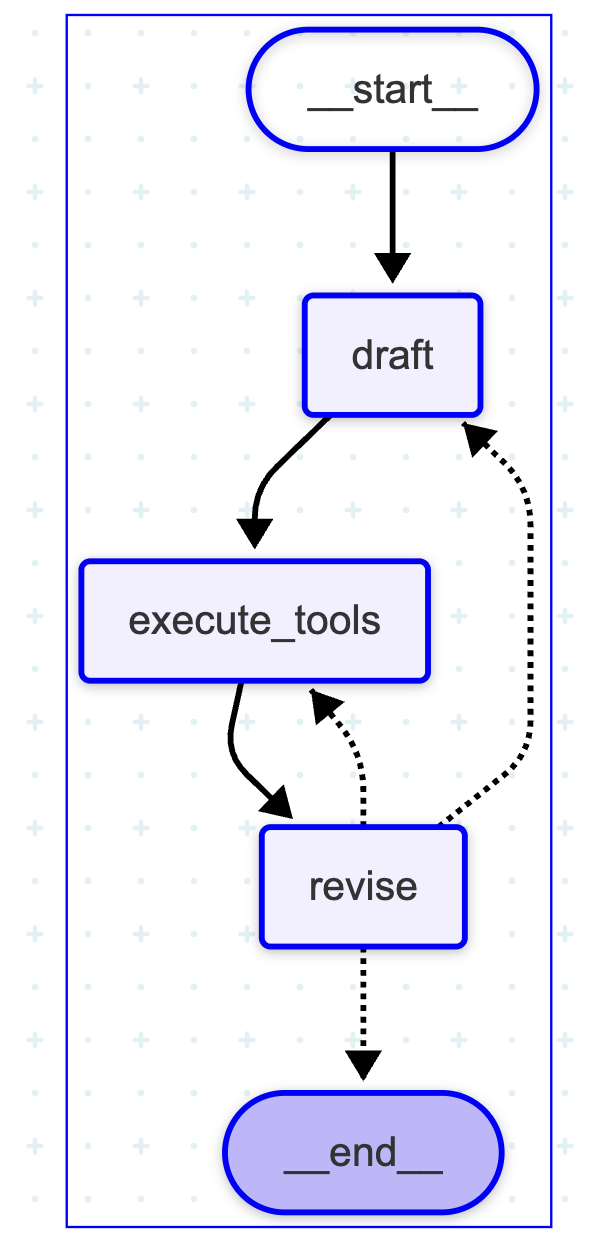

In [106]:
res = graph.invoke(
    "Summarize this cybersecurity incident report in three sentences. After summarizing, review your summary for any missing critical details and revise it."
)
print(res[-1].tool_calls[0]["args"]["answer"])
print(res)

A cybersecurity incident report outlines the details of a security breach or threat, including the nature of the incident, affected systems, and remediation actions taken. It follows a structured approach, often aligned with frameworks such as NIST or SANS, covering preparation, detection, analysis, containment, eradication, recovery, and post-incident activities [1][2]. Furthermore, such reports address compliance with legal and regulatory requirements, detailing any engagements with law enforcement or regulatory bodies as mandated by data protection laws [3]. This comprehensive documentation is crucial for managing and mitigating the impact of cybersecurity incidents, ensuring organizational resilience against future threats.
[HumanMessage(content='Summarize this cybersecurity incident report in three sentences. After summarizing, review your summary for any missing critical details and revise it.', additional_kwargs={}, response_metadata={}, id='ec5c7975-acda-4e35-8f18-a1c541a3fd9a'

In [130]:
from langchain.schema import AIMessage

for i, step in enumerate(res):
    print(f"\nStep {i + 1}: Type = {type(step)}")
    
    if isinstance(step, AIMessage) and step.tool_calls:
        for j, tool_call in enumerate(step.tool_calls):
            args = tool_call.get("args", {})
            answer = args.get("answer", "[No answer found]")
            print(f"  Tool Call {j + 1} Answer: {answer}")
    else:
        print("  No tool call or not an AIMessage.")



Step 1: Type = <class 'langchain_core.messages.human.HumanMessage'>
  No tool call or not an AIMessage.

Step 2: Type = <class 'langchain_core.messages.ai.AIMessage'>
  Tool Call 1 Answer: Due to the nature of the query, I'm unable to provide a summary as the original cybersecurity incident report has not been provided. Without access to the specific details of the cybersecurity incident, including the nature of the breach, entities involved, the impact of the incident, and the response measures taken, it's impossible to generate an accurate and concise summary. Summarizing such a report would typically involve highlighting the key events, the response from the affected parties, and the outcomes or lessons learned.

Step 3: Type = <class 'langchain_core.messages.tool.ToolMessage'>
  No tool call or not an AIMessage.

Step 4: Type = <class 'langchain_core.messages.ai.AIMessage'>
  Tool Call 1 Answer: To write an effective executive summary for a cybersecurity incident report, it's esse